In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## 1. Data Preprocessing:

   - Implement data loading and preprocessing techniques including normalization, resizing, and data augmentation.

In [31]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess CIFAR-10 dataset
train_transform = transforms.Compose([
    transforms.Resize(32), #Resizes the input image to a square of size 32x32 pixels.
    transforms.RandomAdjustSharpness(sharpness_factor=2), #
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Z-score Normalization
])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)  # Each worker can independently load a batch of data while the main process is working on the current batch.(parallelization)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


## 2. Model Building:

   - Design a CNN model from scratch. Ensure the model is appropriate for the task but not overly complex.



In [37]:
# Lets Start by building simple model qith the following layers:
# conv2d ---(Relu)---> MaxPooling-----> Conv2d ----(Relu)--->MaxPool ------>conv2d ----(Relu)---> MaxPool -------->Flatten ------> Linear--(Relu)----->Linear
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model and move the model parameters to the specified device
model = CNN().to(device)

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# model.parameters():   Specifies that the optimizer should update the parameters (weights and biases) of the model.

## 3. Training and Evaluation:

   - Train the model on the dataset, implementing the training loop and optimization process.

   - Evaluate the model's performance on the test set, reporting key metrics such as accuracy, precision, recall, and F1-score.

### 3.1 Train The Model
at each epoch we will train the model then evaluate the performance to keep tracking the model and determine any initialization signs of overfitting

In [38]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to the specified device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward Pass
        outputs = model(inputs)
        #Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad() #reset the gradients of the parameters before each backward pass
        loss.backward()
        optimizer.step()

        # Calculations:

        total_loss += loss.item()

        # extract the predictions
        _, predicted = torch.max(outputs, 1)
        # calculate the number of the correct prediction in the current batch
        correct_predictions += (predicted == labels).sum().item()
        # add number of samples in each batch
        total_samples += labels.size(0)

    # Calculate the accuracy = correct/ total
    accuracy = correct_predictions / total_samples

    # Calculate the average loss = sum of all losses/ Number of mini batches
    average_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    # Validation
    model.eval()
    with torch.no_grad(): # Inside this block, the gradients are not computed during the forward and backward passes.
        validation_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        for val_inputs, val_labels in test_loader:
            # Move inputs and labels to the specified device (CPU or GPU)
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            # Forward Pass
            val_outputs = model(val_inputs)
            # compute the loss
            val_loss = criterion(val_outputs, val_labels)

            # Calculations:
            validation_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)

        val_accuracy = correct_val_predictions / total_val_samples
        val_average_loss = validation_loss / len(test_loader)

        print(f'Validation Loss: {val_average_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

Epoch [1/10], Loss: 1.5145, Accuracy: 45.27%
Validation Loss: 1.2252, Validation Accuracy: 56.22%
Epoch [2/10], Loss: 1.1552, Accuracy: 59.10%
Validation Loss: 1.1135, Validation Accuracy: 60.40%
Epoch [3/10], Loss: 1.0031, Accuracy: 64.75%
Validation Loss: 0.9316, Validation Accuracy: 66.80%
Epoch [4/10], Loss: 0.9148, Accuracy: 67.97%
Validation Loss: 0.8905, Validation Accuracy: 68.98%
Epoch [5/10], Loss: 0.8471, Accuracy: 70.61%
Validation Loss: 0.8496, Validation Accuracy: 70.56%
Epoch [6/10], Loss: 0.8060, Accuracy: 71.94%
Validation Loss: 0.8300, Validation Accuracy: 70.95%
Epoch [7/10], Loss: 0.7648, Accuracy: 73.35%
Validation Loss: 0.7737, Validation Accuracy: 73.49%
Epoch [8/10], Loss: 0.7313, Accuracy: 74.51%
Validation Loss: 0.7718, Validation Accuracy: 73.33%
Epoch [9/10], Loss: 0.7092, Accuracy: 75.27%
Validation Loss: 0.7355, Validation Accuracy: 74.71%
Epoch [10/10], Loss: 0.6856, Accuracy: 76.08%
Validation Loss: 0.7326, Validation Accuracy: 74.93%


### Evaluate The Model **(DRAFT)**

In [ ]:
#@title 1st trial: Testing Accuracy and Classification Report
'''''
import numpy as np
from sklearn.metrics import classification_report

model.eval()
correct, total = 0, 0
predicted_labels, true_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')

# Convert the lists to numpy arrays for classification_report
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Test Accuracy: 73.34%
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.77      1000
           1       0.91      0.84      0.88      1000
           2       0.63      0.62      0.63      1000
           3       0.44      0.70      0.54      1000
           4       0.73      0.65      0.69      1000
           5       0.66      0.62      0.64      1000
           6       0.78      0.82      0.80      1000
           7       0.87      0.69      0.77      1000
           8       0.85      0.86      0.85      1000
           9       0.85      0.82      0.83      1000

    accuracy                           0.73     10000
   macro avg       0.76      0.73      0.74     10000
weighted avg       0.76      0.73      0.74     10000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


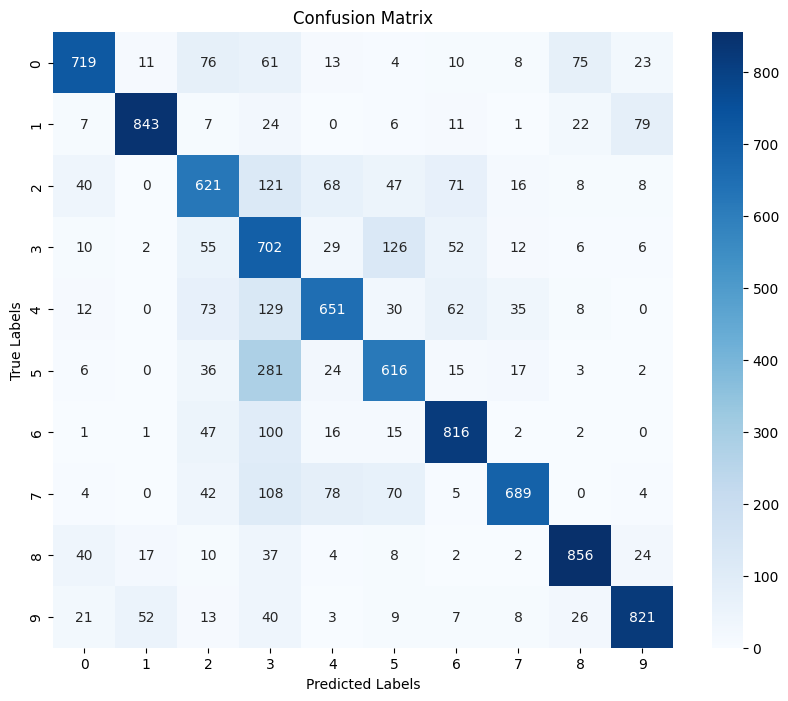

In [ ]:
#@title Confusion Matrix
'''''
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# Assuming you have a DataLoader for your test set
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test set and make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 3.2 Evaluation Function

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model on the test set and generate both classification report and confusion matrix
def evaluate_and_report(model, test_loader, criterion, device):

    # Set the model to evaluation mode
    model.eval()
    correct, total = 0, 0
    true_labels, predicted_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the specified device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)

            # extract the predictions
            _, predicted = torch.max(outputs, 1)

            # gather the true_labels and the predictions
            true_labels.extend(labels.cpu().numpy())  #move the data from the GPU to the CPU because numpy() operates on CPU tensors. then, convert the PyTorch tensor them to numpy array
            predicted_labels.extend(predicted.cpu().numpy())

            # Calculate the Accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    # Convert the lists to numpy arrays for classification_report
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Print the accuracy
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    # Generate and print the classification report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Test Accuracy: 74.93%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1000
           1       0.79      0.92      0.85      1000
           2       0.64      0.68      0.66      1000
           3       0.55      0.64      0.59      1000
           4       0.72      0.72      0.72      1000
           5       0.68      0.64      0.66      1000
           6       0.84      0.80      0.82      1000
           7       0.84      0.77      0.80      1000
           8       0.82      0.85      0.84      1000
           9       0.92      0.72      0.81      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



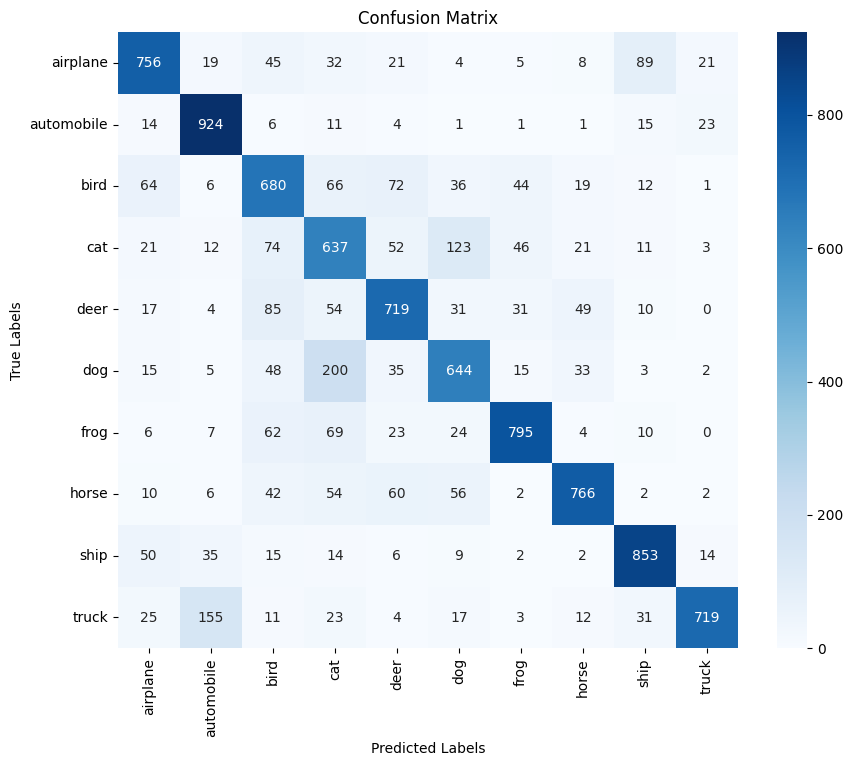

In [40]:
evaluate_and_report(model, test_loader, criterion, device)

its obious that class 3 and 5 got a low precision and recall and by visualizing the confusion matrix we can determine that the model miss classify (200) dogs and classify them as cats. hence we may need to apply one or more of the following:
- More complex model to detect the feature more specific features
- Increase the cats and dogs samples

lets start by using a more complex model since we also have the same problem between trucks and automobile

## 4. Hyperparameter Tuning:

   - Experiment with various hyperparameters to optimize the model.

### 4.1) Explore different archietecture

In [43]:
class model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)
# Instantiate the model, loss function, and optimizer
model = model2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    # Validation
    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            validation_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)

        val_accuracy = correct_val_predictions / total_val_samples
        val_average_loss = validation_loss / len(test_loader)

        print(f'Validation Loss: {val_average_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')


Epoch [1/10], Loss: 1.6015, Accuracy: 40.10%
Validation Loss: 1.2635, Validation Accuracy: 54.30%
Epoch [2/10], Loss: 1.1249, Accuracy: 59.30%
Validation Loss: 1.0122, Validation Accuracy: 64.16%
Epoch [3/10], Loss: 0.9285, Accuracy: 67.04%
Validation Loss: 0.8748, Validation Accuracy: 69.10%
Epoch [4/10], Loss: 0.8036, Accuracy: 71.67%
Validation Loss: 0.7958, Validation Accuracy: 73.28%
Epoch [5/10], Loss: 0.7215, Accuracy: 74.80%
Validation Loss: 0.6931, Validation Accuracy: 76.21%
Epoch [6/10], Loss: 0.6635, Accuracy: 76.79%
Validation Loss: 0.6877, Validation Accuracy: 75.81%
Epoch [7/10], Loss: 0.6160, Accuracy: 78.46%
Validation Loss: 0.6650, Validation Accuracy: 77.56%
Epoch [8/10], Loss: 0.5795, Accuracy: 79.67%
Validation Loss: 0.6434, Validation Accuracy: 77.98%
Epoch [9/10], Loss: 0.5469, Accuracy: 80.93%
Validation Loss: 0.6043, Validation Accuracy: 79.76%
Epoch [10/10], Loss: 0.5201, Accuracy: 81.82%
Validation Loss: 0.5928, Validation Accuracy: 79.65%


Test Accuracy: 79.65%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1000
           1       0.90      0.91      0.91      1000
           2       0.72      0.71      0.72      1000
           3       0.57      0.70      0.63      1000
           4       0.77      0.77      0.77      1000
           5       0.75      0.69      0.72      1000
           6       0.86      0.79      0.82      1000
           7       0.90      0.80      0.85      1000
           8       0.87      0.89      0.88      1000
           9       0.92      0.83      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



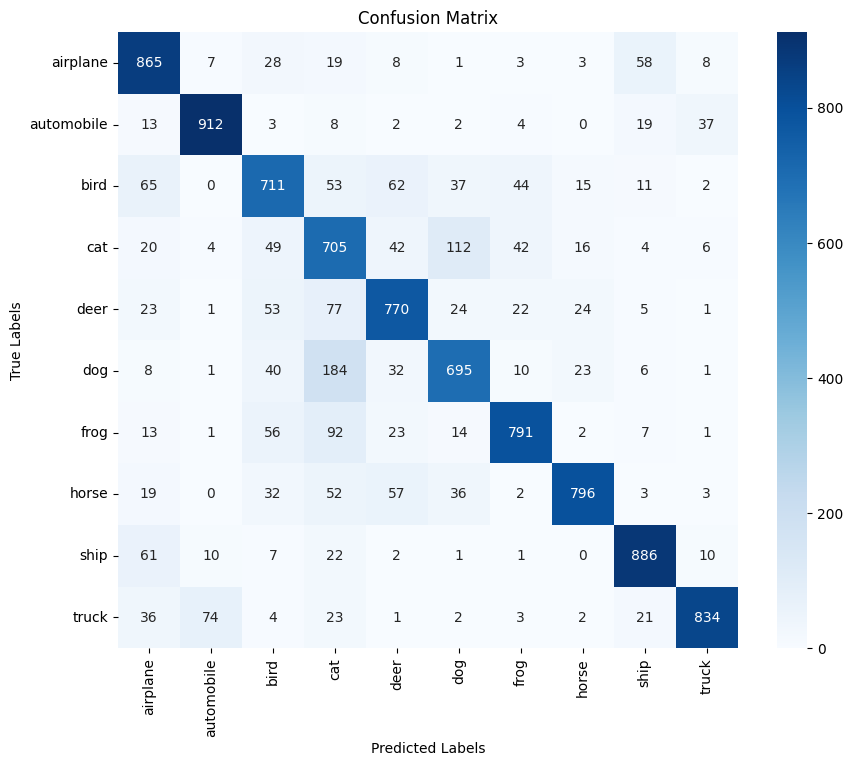

In [45]:
evaluate_and_report(model, test_loader, criterion, device)

The increase in the models complexity led to a better performance. however there is still some miss classification between dogs and cats classes. we can do one or more of the following:
- add more complex data augmentation methods
- add more samples for those classes
- add more complexity to the model
- increase number of epochs aslong as the model is not overfitting

archeticture inspired from the following Reference: https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch

**Results:** The first option *(add more complex data augmentation methods
)* did not yield positive results; in fact, it led to a decrease in performance. Moreover, it demands numerous iterations to identify more effective augmentation techniques.


Let's first explore hyperparameter tuning aiming to achieve better convergence.







### 4.2) Tune The Learning Rate

In [46]:
learning_rates = {
    'lr_0': 0.0001,
    'lr_1': 0.0003,
    'lr_2': 0.001,
    'lr_3': 0.003,
}

# Assuming you have a model, criterion, and train_loader defined earlier

# Loop through each learning rate
for lr_name, learning_rate in learning_rates.items():
    # Create a new model instance for each learning rate

    model = model2().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Define optimizer with the current learning rate

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        accuracy = correct_predictions / total_samples
        average_loss = running_loss / len(train_loader)

        print(f'{lr_name} - Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    # Store the accuracy in the dictionary
    learning_rates[lr_name] = accuracy * 100

# Print the dictionary with accuracy for each learning rate
print(learning_rates)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


lr_0 - Epoch [1/10], Loss: 1.6638, Accuracy: 37.22%
lr_0 - Epoch [2/10], Loss: 1.1391, Accuracy: 59.05%
lr_0 - Epoch [3/10], Loss: 0.9158, Accuracy: 67.42%
lr_0 - Epoch [4/10], Loss: 0.7877, Accuracy: 72.27%
lr_0 - Epoch [5/10], Loss: 0.7034, Accuracy: 75.16%
lr_0 - Epoch [6/10], Loss: 0.6444, Accuracy: 77.33%
lr_0 - Epoch [7/10], Loss: 0.5920, Accuracy: 79.32%
lr_0 - Epoch [8/10], Loss: 0.5538, Accuracy: 80.74%
lr_0 - Epoch [9/10], Loss: 0.5260, Accuracy: 81.52%
lr_0 - Epoch [10/10], Loss: 0.4971, Accuracy: 82.74%
lr_1 - Epoch [1/10], Loss: 1.6122, Accuracy: 39.84%
lr_1 - Epoch [2/10], Loss: 1.1210, Accuracy: 59.63%
lr_1 - Epoch [3/10], Loss: 0.9174, Accuracy: 67.24%
lr_1 - Epoch [4/10], Loss: 0.7913, Accuracy: 72.19%
lr_1 - Epoch [5/10], Loss: 0.7054, Accuracy: 75.44%
lr_1 - Epoch [6/10], Loss: 0.6413, Accuracy: 77.77%
lr_1 - Epoch [7/10], Loss: 0.5973, Accuracy: 79.06%
lr_1 - Epoch [8/10], Loss: 0.5578, Accuracy: 80.48%
lr_1 - Epoch [9/10], Loss: 0.5288, Accuracy: 81.51%
lr_1 - Epoc

lr_2 = 0.001 performs better so we will stick with it



### 4.3) increase Number of epochs

In [47]:
num_epochs = 30
model = model2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    # Validation
    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            validation_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)

        val_accuracy = correct_val_predictions / total_val_samples
        val_average_loss = validation_loss / len(test_loader)

        print(f'Validation Loss: {val_average_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

Epoch [1/30], Loss: 1.6260, Accuracy: 39.04%
Validation Loss: 1.2972, Validation Accuracy: 52.38%
Epoch [2/30], Loss: 1.1310, Accuracy: 59.17%
Validation Loss: 1.0074, Validation Accuracy: 64.56%
Epoch [3/30], Loss: 0.9045, Accuracy: 68.30%
Validation Loss: 0.8220, Validation Accuracy: 71.53%
Epoch [4/30], Loss: 0.7847, Accuracy: 72.62%
Validation Loss: 0.7990, Validation Accuracy: 71.37%
Epoch [5/30], Loss: 0.7066, Accuracy: 75.25%
Validation Loss: 0.7268, Validation Accuracy: 75.56%
Epoch [6/30], Loss: 0.6517, Accuracy: 77.28%
Validation Loss: 0.6473, Validation Accuracy: 77.81%
Epoch [7/30], Loss: 0.6055, Accuracy: 78.73%
Validation Loss: 0.6208, Validation Accuracy: 78.79%
Epoch [8/30], Loss: 0.5690, Accuracy: 80.15%
Validation Loss: 0.6282, Validation Accuracy: 79.33%
Epoch [9/30], Loss: 0.5395, Accuracy: 81.24%
Validation Loss: 0.5911, Validation Accuracy: 80.06%
Epoch [10/30], Loss: 0.5142, Accuracy: 81.92%
Validation Loss: 0.5755, Validation Accuracy: 81.08%
Epoch [11/30], Loss

KeyboardInterrupt: 

From epoch 13, the model began to exhibit signs of overfitting. The outcomes were monitored until epoch 20; however, there was an observable trend where the training accuracy increased, while the validation accuracy continued to decline. I am inclined to consider epochs 10 to 12 as a suitable range. Alternatively, we may need to introduce **regularization** or add a **dropout** layer to the network and reevaluate the results.







Test Accuracy: 82.13%
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.91      0.92      0.92      1000
           2       0.71      0.79      0.74      1000
           3       0.64      0.70      0.67      1000
           4       0.83      0.77      0.80      1000
           5       0.79      0.70      0.74      1000
           6       0.90      0.85      0.87      1000
           7       0.83      0.88      0.86      1000
           8       0.92      0.88      0.90      1000
           9       0.87      0.90      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



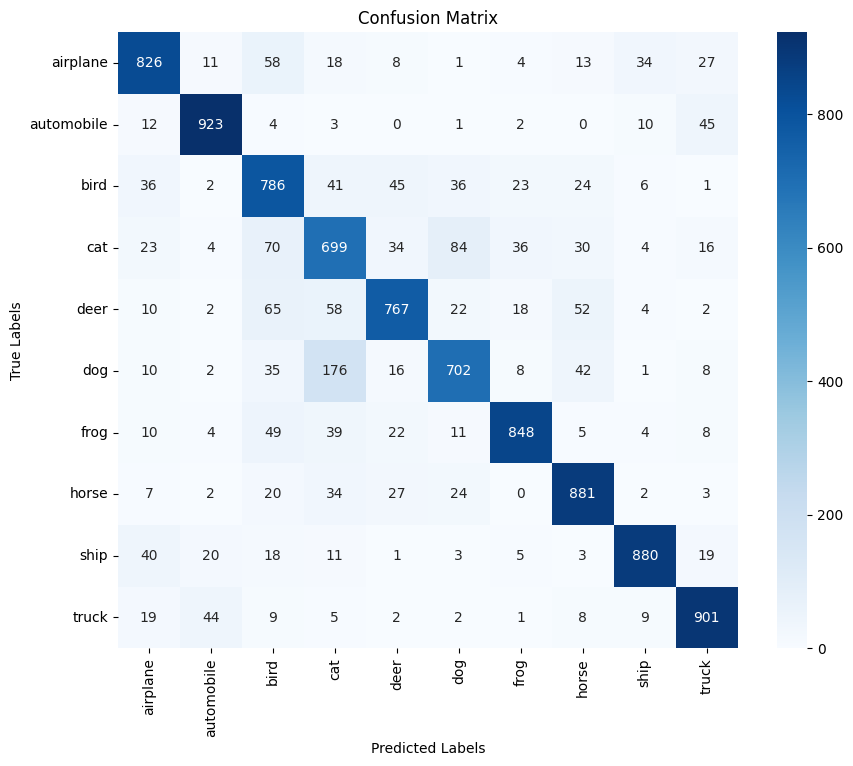

In [48]:
evaluate_and_report(model, test_loader, criterion, device)

### 4.4) Regularization

In [49]:
num_epochs = 15
model = model2().to(device)
criterion = nn.CrossEntropyLoss()
# Add Regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    # Validation
    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            validation_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)

        val_accuracy = correct_val_predictions / total_val_samples
        val_average_loss = validation_loss / len(test_loader)

        print(f'Validation Loss: {val_average_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/15], Loss: 1.6773, Accuracy: 36.30%
Validation Loss: 1.3117, Validation Accuracy: 51.81%
Epoch [2/15], Loss: 1.1741, Accuracy: 57.01%
Validation Loss: 1.0150, Validation Accuracy: 64.47%
Epoch [3/15], Loss: 0.9514, Accuracy: 66.09%
Validation Loss: 0.8332, Validation Accuracy: 70.59%
Epoch [4/15], Loss: 0.8199, Accuracy: 71.15%
Validation Loss: 0.8085, Validation Accuracy: 71.79%
Epoch [5/15], Loss: 0.7341, Accuracy: 74.27%
Validation Loss: 0.7278, Validation Accuracy: 75.07%
Epoch [6/15], Loss: 0.6736, Accuracy: 76.46%
Validation Loss: 0.7003, Validation Accuracy: 75.88%
Epoch [7/15], Loss: 0.6217, Accuracy: 78.12%
Validation Loss: 0.6406, Validation Accuracy: 77.93%
Epoch [8/15], Loss: 0.5830, Accuracy: 79.65%
Validation Loss: 0.6019, Validation Accuracy: 79.52%
Epoch [9/15], Loss: 0.5523, Accuracy: 80.63%
Validation Loss: 0.5613, Validation Accuracy: 81.27%
Epoch [10/15], Loss: 0.5265, Accuracy: 81.70%
Validation Loss: 0.5547, Validation Accuracy: 81.14%
Epoch [11/15], Loss

Test Accuracy: 81.95%
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1000
           1       0.85      0.96      0.90      1000
           2       0.73      0.78      0.75      1000
           3       0.65      0.71      0.68      1000
           4       0.89      0.73      0.80      1000
           5       0.71      0.79      0.75      1000
           6       0.87      0.85      0.86      1000
           7       0.94      0.79      0.86      1000
           8       0.92      0.86      0.89      1000
           9       0.92      0.85      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



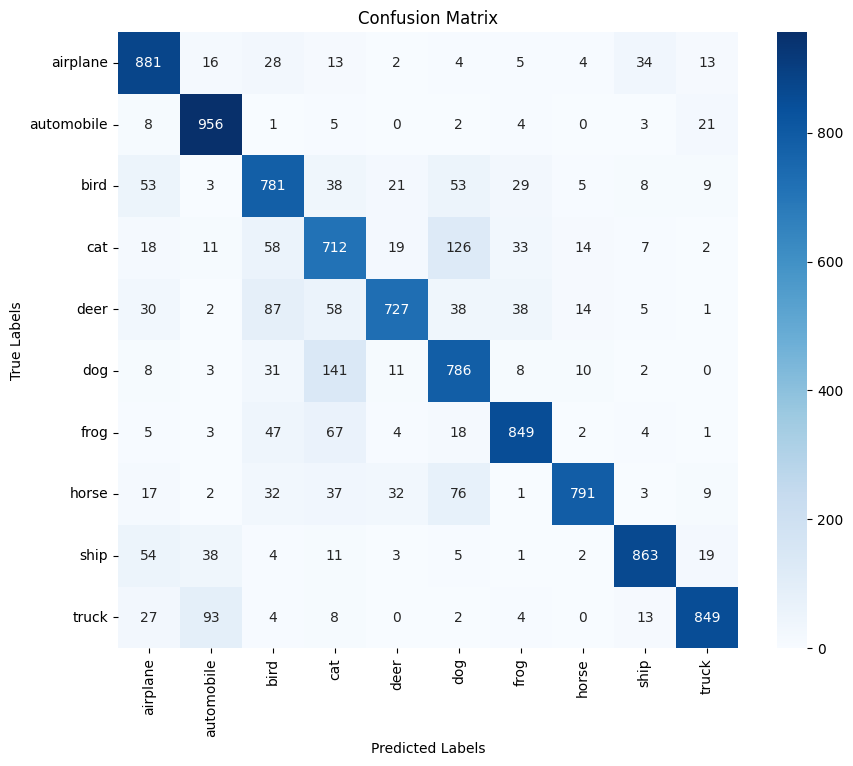

In [50]:
evaluate_and_report(model, test_loader, criterion, device)

## Conclusion
- The model seems to perform reasonably well, with a test accuracy improved to 81.95% instead of 74.93%.
- Some classes perform better than others, as seen in variations in precision, recall, and F1-score. Two potential strategies are suggested:  
1) Enhancing and adding complexity to the model to capture more features.  
2) Introducing more samples and applying augmentation techniques to increase the performance of classes with lower F1 Score.